![](https://img.shields.io/badge/CNES_AVISO-Contribution-%20?color=grey&labelColor=blue)


# Download Swot from AVISO
This notebook explains how to explore and retrieve available SWOT LR data from AVISO's THREDDS Data Server and FTP Server, presented [here](https://www.aviso.altimetry.fr/en/missions/current-missions/swot/access-to-data.html).

L2 data can be explored at: https://tds.aviso.altimetry.fr/thredds/L2/L2-SWOT-DATA/L2-SWOT.html

L3 data can be explored at: https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/catalog.html


## Tutorial Objectives
* Discover Aviso's Thredds Data Server catalogue
* Download files through HTTP and FTP
* Download data subset through Opendap



## Import + code



In [1]:
import os
import re
from getpass import getpass
import requests as rq
import ftplib
import xarray as xr
from xarray.backends import PydapDataStore

In [2]:
def _get_filename_from_cd(cd):
    """ Get filename from content-disposition """
    if not cd:
        return None
    fname = re.findall('filename="(.+)"', cd)
    if len(fname) == 0:
        return None
    return fname[0]

def http_download_file(dataset_url:str, output_path:str):
    response = rq.get(dataset_url, auth=(username, password))
    
    filename = _get_filename_from_cd(response.headers['content-disposition'])
    file_path = os.path.join(output_path, filename)
    
    open(file_path, 'wb').write(response.content)
    return file_path

def _download_file(ftp:str, filename:str, target_directory:str):
    try:
        local_filepath = os.path.join(target_directory, filename)
        with open(local_filepath, 'wb') as file:
            ftp.retrbinary('RETR %s' % filename, file.write)
            print(f"Downloaded {filename} to {target_directory}")
            return local_filepath
    except Exception as e:
        print(f"Error downloading {filename}: {e}")
        
def ftp_download_file(ftp_path:str, filename:str, output_path:str):
    # Set up FTP server details
    ftpAVISO = 'ftp-access.aviso.altimetry.fr'
    try:
        # Logging into FTP server using provided credentials
        with ftplib.FTP(ftpAVISO) as ftp:
            ftp.login(username, password)
            ftp.cwd(ftp_path)
            print(f"Connection Established {ftp.getwelcome()}")

            # Check if the file exists in the directory
            if filename in ftp.nlst():
                return _download_file(ftp, filename, output_path)
            else:
                print(f"File {filename} does not exist in the directory {ftp}.")
    except ftplib.error_perm as e:
        print(f"FTP error: {e}")
    except Exception as e:
        print(f"Error: {e}")


def open_opendap_dataset(dataset_url):
    session = rq.Session()
    session.auth = (username, password)
    store = PydapDataStore.open(dataset_url, session=session, timeout=300, user_charset='UTF-8')
    return xr.open_dataset(store)

## Parameters
Define output folder to save results



In [3]:
output_dir = "downloads"

### Authentication parameters
Enter your AVISO+ credentials



In [ ]:
password = getpass(f"Enter password for {username}:")

In [ ]:
username = input("Enter username:")

## Download files through HTTP
To find the data you want to download, you can explore the [Swot LR L2](https://tds.aviso.altimetry.fr/thredds/L2/L2-SWOT-DATA/L2-SWOT.html) or [Swot LR L3](https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/catalog.html) catalogues.

Copy the **FileServer** url to download data through HTTP : 
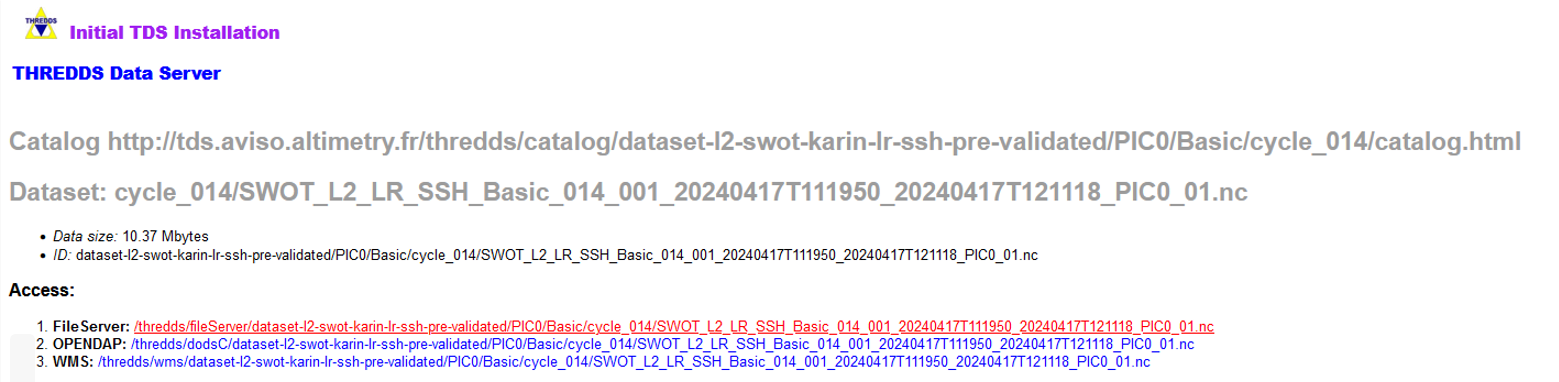

### Swot LR L2 data



In [5]:
l2_dataset_url = "https://tds.aviso.altimetry.fr/thredds/fileServer/dataset-l2-swot-karin-lr-ssh-pre-validated/PIC0/Basic/cycle_014/SWOT_L2_LR_SSH_Basic_014_001_20240417T111950_20240417T121118_PIC0_01.nc"

In [6]:
l2_file = http_download_file(l2_dataset_url, output_dir)
l2_file

'downloads/SWOT_L2_LR_SSH_Basic_014_001_20240417T111950_20240417T121118_PIC0_01.nc'

### Swot LR L3 data



In [7]:
l3_dataset_url = "https://tds.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-pre-validated/l3_lr_ssh/v1_0/Basic/cycle_014/SWOT_L3_LR_SSH_Basic_014_001_20240417T111950_20240417T121116_v1.0.nc"

In [8]:
l3_file = http_download_file(l3_dataset_url, output_dir)
l3_file

'downloads/SWOT_L3_LR_SSH_Basic_014_001_20240417T111950_20240417T121116_v1.0.nc'

## Download files through FTP
Files available through FTP follow the same file tree as in the THREDDS Data Server.

| Data | FTP starting point | Browsing files URL |
| --- | --- | --- |
| Swot LR L2 | */swot_products/l2_karin/l2_lr_ssh* | https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l2-swot-karin-lr-ssh-pre-validated/catalog.html |
| Swot LR L3 | */swot_products/l3_karin_nadir/l3_lr_ssh* | https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/catalog.html |

### Swot LR L2 data



In [9]:
l2_ftp_path = '/swot_products/l2_karin/l2_lr_ssh/PGC0/WindWave/cycle_001/'
l2_ftp_file = 'SWOT_L2_LR_SSH_WindWave_001_155_20230726T173636_20230726T182805_PGC0_01.nc'

In [10]:
l2_file = ftp_download_file(l2_ftp_path, l2_ftp_file, output_dir)
l2_file

Connection Established 220 192.168.10.119 FTP server ready
Downloaded SWOT_L2_LR_SSH_WindWave_001_155_20230726T173636_20230726T182805_PGC0_01.nc to downloads


'downloads/SWOT_L2_LR_SSH_WindWave_001_155_20230726T173636_20230726T182805_PGC0_01.nc'

### Swot LR L3 data



In [11]:
l3_ftp_path = '/swot_products/l3_karin_nadir/l3_lr_ssh/v1_0/Basic/cycle_011/'
l3_ftp_file = 'SWOT_L3_LR_SSH_Basic_011_550_20240305T114902_20240305T124029_v1.0.nc'

In [12]:
l3_file = ftp_download_file(l3_ftp_path, l3_ftp_file, output_dir)
l3_file

Connection Established 220 192.168.10.119 FTP server ready
Downloaded SWOT_L3_LR_SSH_Basic_011_550_20240305T114902_20240305T124029_v1.0.nc to downloads


'downloads/SWOT_L3_LR_SSH_Basic_011_550_20240305T114902_20240305T124029_v1.0.nc'

## Load subset via OPeNDAP
To find the data you want to subset, you can explore the [Swot LR L2](https://tds.aviso.altimetry.fr/thredds/L2/L2-SWOT-DATA/L2-SWOT.html) or [Swot LR L3](https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/catalog.html) catalogues.

Copy the **OPeNDAP** url to subset data through Opendap : 
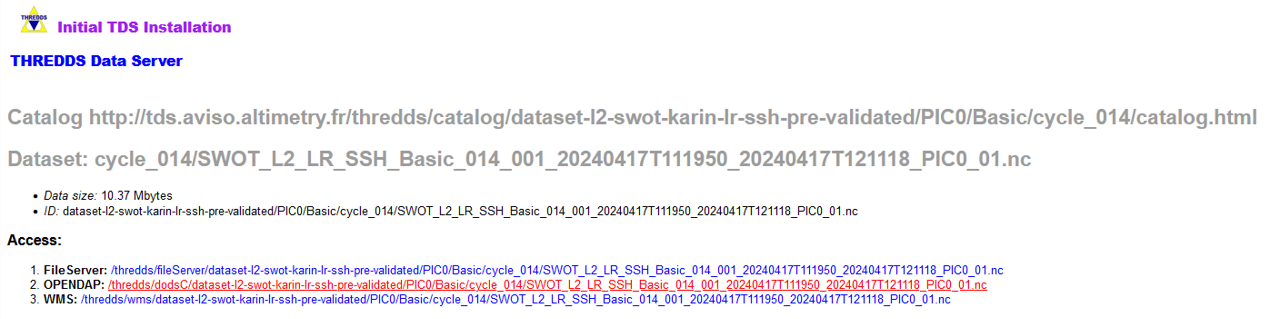

### Swot LR L2 data



In [13]:
l2_dataset_url = "https://tds.aviso.altimetry.fr/thredds/dodsC/dataset-l2-swot-karin-lr-ssh-pre-validated/PIC0/Basic/cycle_014/SWOT_L2_LR_SSH_Basic_014_001_20240417T111950_20240417T121118_PIC0_01.nc"

In [14]:
l2_dataset = open_opendap_dataset(l2_dataset_url)
l2_dataset

<xarray.Dataset>
Dimensions:                                (num_lines: 9866, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 ...
    longitude                              (num_lines, num_pixels) float64 ...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/24)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ...                                     ...
    mean_sea_surface_cnescls               (num_lines, num_pixels) float64 ...
    mean_sea_surface_cnescls_uncert        (num_lines, num_pixels) float32 ...
    geoid                                  (num_lines, num_pixels) float64 ...
    internal_tide_hret                     (num_lines, num_pixels) float32 ...
    height_cor_xover                       (num_lines, num_pixels) float64 ...
    height_cor_xover_qual                  (num_lines, num_pixels) float32 ...
Attributes: (12/63)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   CNES
    source:                                        Ka-band radar interferometer
    history:                                       2024-04-19T22:01:03Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       63.07686914249655
    ssha_variance:                                 1.1479401224317318
    _NCProperties:                                 version=2,netcdf=4.9.2,hdf...
    references:                                    V1.2.1
    equator_longitude:                             0.17

#### Select variables



In [15]:
variables = ['time', 'ssha_karin_2', 'mean_sea_surface_cnescls']

In [16]:
ds = l2_dataset[variables]
ds

<xarray.Dataset>
Dimensions:                   (num_lines: 9866, num_pixels: 69)
Coordinates:
    latitude                  (num_lines, num_pixels) float64 ...
    longitude                 (num_lines, num_pixels) float64 ...
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    time                      (num_lines) datetime64[ns] ...
    ssha_karin_2              (num_lines, num_pixels) float64 ...
    mean_sea_surface_cnescls  (num_lines, num_pixels) float64 ...
Attributes: (12/63)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   CNES
    source:                                        Ka-band radar interferometer
    history:                                       2024-04-19T22:01:03Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       63.07686914249655
    ssha_variance:                                 1.1479401224317318
    _NCProperties:                                 version=2,netcdf=4.9.2,hdf...
    references:                                    V1.2.1
    equator_longitude:                             0.17

#### Select lines
Select lines to load



In [17]:
idx_first, idx_last = 5000, 6000

In [18]:
ds = xr.merge([ds[var][idx_first:idx_last] for var in variables])

In [19]:
ds.load()

<xarray.Dataset>
Dimensions:                   (num_lines: 1000, num_pixels: 69)
Coordinates:
    latitude                  (num_lines, num_pixels) float64 1.297 ... 18.96
    longitude                 (num_lines, num_pixels) float64 359.7 ... 3.747
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    time                      (num_lines) datetime64[ns] 2024-04-17T11:45:57....
    ssha_karin_2              (num_lines, num_pixels) float64 nan -2.287 ... nan
    mean_sea_surface_cnescls  (num_lines, num_pixels) float64 17.35 ... 25.86
Attributes:
    long_name:           time in UTC
    standard_name:       time
    tai_utc_difference:  37.0
    leap_second:         0000-00-00T00:00:00Z
    comment:             Time of measurement in seconds in the UTC time scale...
    _ChunkSizes:         9866

### Swot LR L3 data



In [20]:
l3_dataset_url = "https://tds.aviso.altimetry.fr/thredds/dodsC/dataset-l3-swot-karin-nadir-pre-validated/l3_lr_ssh/v1_0/Basic/cycle_014/SWOT_L3_LR_SSH_Basic_014_350_20240429T223450_20240429T232617_v1.0.nc"

In [21]:
l3_dataset = open_opendap_dataset(l3_dataset_url)
l3_dataset

<xarray.Dataset>
Dimensions:         (num_lines: 9860, num_pixels: 69, num_nadir: 2095)
Coordinates:
    latitude        (num_lines, num_pixels) float64 ...
    longitude       (num_lines, num_pixels) float64 ...
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables:
    time            (num_lines) datetime64[ns] ...
    mdt             (num_lines, num_pixels) float64 ...
    ssha            (num_lines, num_pixels) float64 ...
    ssha_noiseless  (num_lines, num_pixels) float64 ...
    i_num_line      (num_nadir) int16 ...
    i_num_pixel     (num_nadir) int8 ...
Attributes: (12/43)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PIC0 (NASA/CNES). D...
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    ...                              ...
    time_coverage_end:               2024-04-29T23:26:17Z
    geospatial_lat_min:              -78.271903
    geospatial_lat_max:              78.272068
    geospatial_lon_min:              0.000145
    geospatial_lon_max:              359.999524
    _NCProperties:                   version=2,netcdf=4.9.2,hdf5=1.14.1

#### Select variables



In [22]:
variables = ['time', 'ssha']

In [23]:
ds = l3_dataset[variables]
ds

<xarray.Dataset>
Dimensions:    (num_lines: 9860, num_pixels: 69)
Coordinates:
    latitude   (num_lines, num_pixels) float64 ...
    longitude  (num_lines, num_pixels) float64 ...
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    time       (num_lines) datetime64[ns] ...
    ssha       (num_lines, num_pixels) float64 ...
Attributes: (12/43)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PIC0 (NASA/CNES). D...
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    ...                              ...
    time_coverage_end:               2024-04-29T23:26:17Z
    geospatial_lat_min:              -78.271903
    geospatial_lat_max:              78.272068
    geospatial_lon_min:              0.000145
    geospatial_lon_max:              359.999524
    _NCProperties:                   version=2,netcdf=4.9.2,hdf5=1.14.1

#### Select lines
Select lines to load



In [24]:
idx_first, idx_last = 5000, 6000

In [25]:
ds = xr.merge([ds[var][idx_first:idx_last] for var in variables])

In [26]:
ds.load()

<xarray.Dataset>
Dimensions:    (num_lines: 1000, num_pixels: 69)
Coordinates:
    latitude   (num_lines, num_pixels) float64 -1.155 -1.157 ... -19.19 -19.2
    longitude  (num_lines, num_pixels) float64 343.1 343.1 343.1 ... 344.6 344.6
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    time       (num_lines) datetime64[ns] 2024-04-29T23:00:53.917956864 ... 2...
    ssha       (num_lines, num_pixels) float64 nan nan nan nan ... nan nan nan
Attributes:
    comment:             Time of measurement in seconds in the UTC time scale...
    leap_second:         0000-00-00T00:00:00Z
    long_name:           time in UTC
    standard_name:       time
    tai_utc_difference:  37.0
    _ChunkSizes:         9860

### Store subset to NetCDF file



In [ ]:
ds.to_netcdf(os.path.join(output_dir, 'dataset.nc'))